In [1]:
import os
import datetime
import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt
#import shap

import sys
sys.path.append('/home/rluser/TactileDriven_Arto/UTILITIES')
from PreProcessingFunctions import myfilter, num_transient, sliding_sum_window, select_index, add_padding
from PreProcessingFunctions import WS, WS_B
from PreProcessingFunctions import rename_and_convert_to_txt

from Performance_plotter import plot_f1_score_threshold, plot_precision_recall_curve, plot_confusion_matrix, plot_roc_curve
from XAI_FCN import plot_grad_cam

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report

import tensorflow
gpus = tensorflow.config.list_physical_devices('GPU')
# if gpus:    
#     for gpu in gpus:
#         tensorflow.config.set_logical_device_configuration(
#             gpu,
#             [tensorflow.config.LogicalDeviceConfiguration(memory_limit=4*1024)])  # Adjust memory limit as needed

from tensorflow.keras.models     import Sequential, Model, load_model
from tensorflow.keras.layers     import Input, Conv1D, Conv2D, BatchNormalization
from tensorflow.keras.layers     import Flatten, Dense, MaxPooling1D, MaxPooling2D, GlobalMaxPooling1D
from tensorflow.keras.layers     import LeakyReLU, ReLU, Activation, Dropout, Lambda
from tensorflow.keras.layers     import concatenate, Concatenate
from tensorflow.keras.optimizers import Adam, AdamW
from tensorflow.keras.losses     import BinaryCrossentropy
from tensorflow.keras.metrics    import AUC, Precision, Recall
from tensorflow.keras.callbacks  import EarlyStopping


data_folder = '/home/rluser/TactileDriven_Arto/ML_Buttons/DATA/1D_TRANSF_FTP_NotNorm/'

def load_data(data_folder):
    X_data = []
    y_data = []
    # Get list of all .npz files in the data folder
    npz_files = [file for file in os.listdir(data_folder) if file.endswith('.npz')]
    
    # Load data from each .npz file
    for file in npz_files:
        file_path = os.path.join(data_folder, file)
        data = np.load(file_path)
        X_data.append(data['X'])  # Assuming X_data is stored under 'X' key in the .npz file
        y_data.append(data['y'])  # Assuming y_data is stored under 'y' key in the .npz file
        data.close()
    
    # Convert lists to NumPy arrays
    X_data = np.array(X_data)
    y_data = np.array(y_data)
    
    return X_data, y_data

import tensorflow as tf

# Function to generate Grad-CAM heatmap
def grad_cam(model, layer_name, data):
    grad_model = tf.keras.models.Model(
        [model.input], [model.get_layer(layer_name).output, model.output]
    )
    last_conv_layer_output, preds = grad_model(data)
    
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(data)
        pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
        
    grads = tape.gradient(class_channel, last_conv_layer_output)
    
    pooled_grads = tf.reduce_mean(grads, axis=(0))
    
    last_conv_layer_output = last_conv_layer_output[0]
    
    heatmap = last_conv_layer_output * pooled_grads
    heatmap = tf.reduce_mean(heatmap, axis=(1))
    heatmap = np.expand_dims(heatmap,0)
    return heatmap

# Load the data
X_data, y_data = load_data(data_folder)

# Check the shape of loaded data
print("X_data shape:", X_data.shape)
print("y_data shape:", y_data.shape)
print("X_data.[0] shape: ", X_data[0].shape)

TEST_SIZE = 0.4
X_train, X_temp, y_train, y_temp = train_test_split(X_data, y_data, test_size=TEST_SIZE, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"TOTAL DATA: {len(X_data)}  ||  Train = {100*(1-TEST_SIZE)}%  ||  Test = {100*TEST_SIZE}%")
print("Dimensions of X_train:", X_train.shape, "   ||  Dimensions of y_train:", y_train.shape)
print("Dimensions of X_test: ", X_test.shape, "   ||  Dimensions of y_test: ", y_test.shape)
print("Dimensions of X_val:  ", X_val.shape, "   ||  Dimensions of y_val:  ", y_val.shape)

2024-09-04 17:12:31.512440: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-04 17:12:32.503102: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-09-04 17:12:33.115239: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2024-09-04 17:12:33.115260: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:134] retrieving CUDA diagnostic information for host: rluser
2024-09-04 17:12:33.115265: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:141] hostname: rluser
2024-09-04 17:12:33.115338: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:165] libcuda reported version is: 535.183.1
2024

X_data shape: (1465, 800)
y_data shape: (1465,)
X_data.[0] shape:  (800,)
TOTAL DATA: 1465  ||  Train = 60.0%  ||  Test = 40.0%
Dimensions of X_train: (879, 800)    ||  Dimensions of y_train: (879,)
Dimensions of X_test:  (293, 800)    ||  Dimensions of y_test:  (293,)
Dimensions of X_val:   (293, 800)    ||  Dimensions of y_val:   (293,)


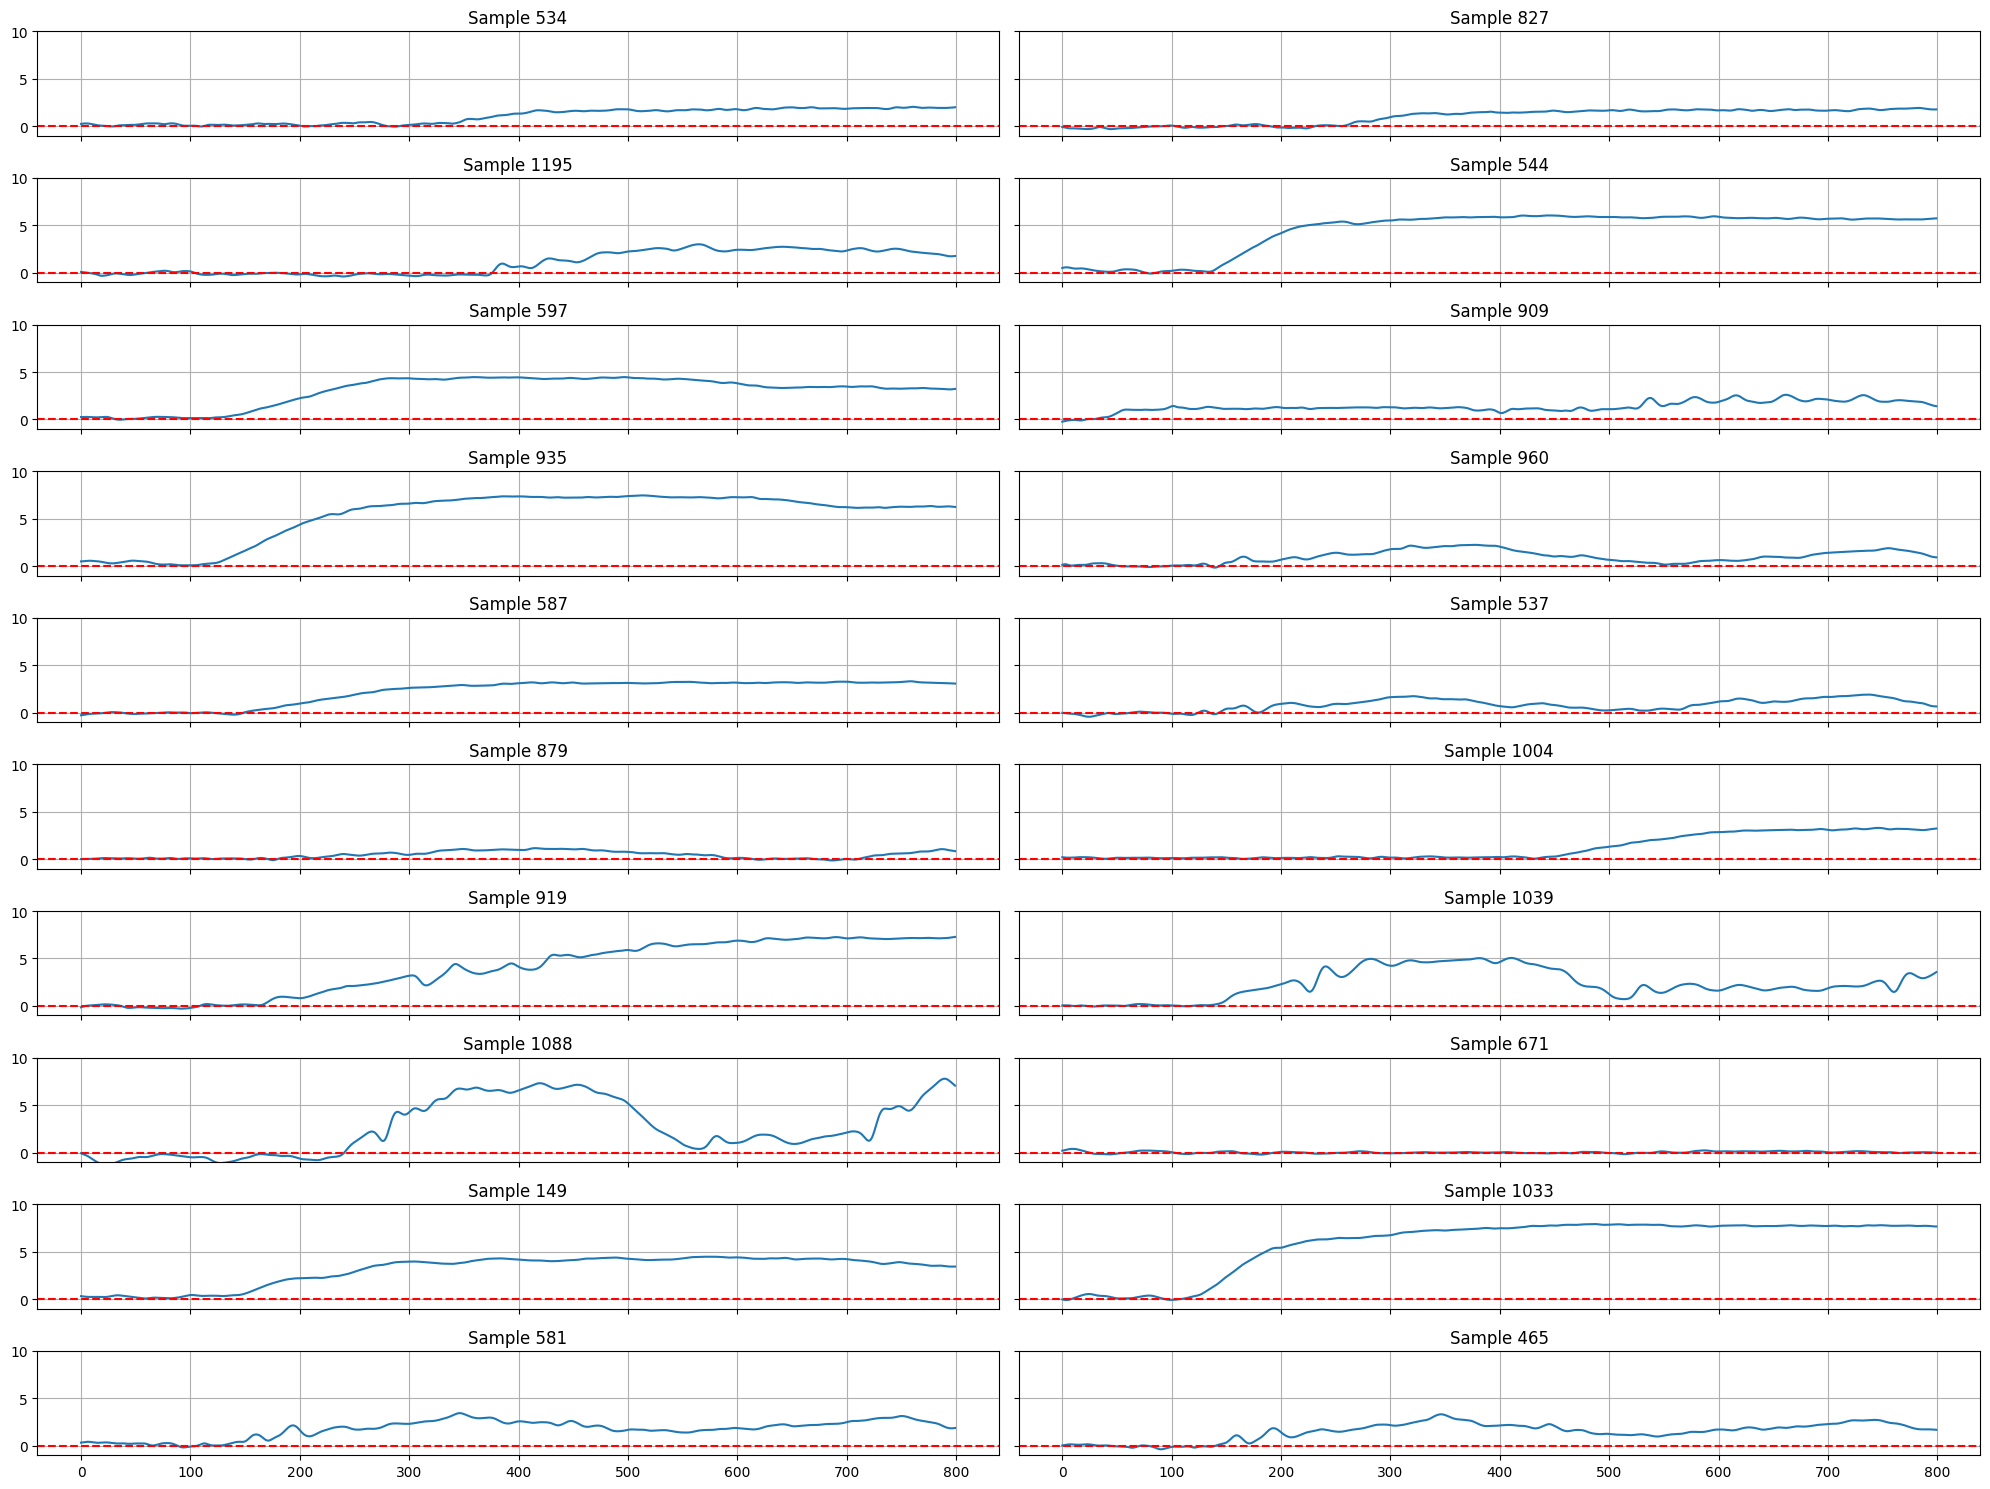

In [2]:

# Function to plot 20 random samples from X_data in different subplots
def plot_random_samples_in_subplots(X_data, num_samples=20):
    indices = np.random.choice(X_data.shape[0], num_samples, replace=False)
    random_samples = X_data[indices]
    
    fig, axes = plt.subplots(nrows=10, ncols=2, figsize=(20, 15), sharex=True, sharey=True)
    axes = axes.flatten()
    
    for i, sample in enumerate(random_samples):
        mean_value = np.mean(sample)
        if mean_value < 0:
            axes[i].set_facecolor('lightcoral')  # Set background color to red if mean < 0
        
        axes[i].plot(sample)
        axes[i].set_ylim(-1, 10)
        axes[i].axhline(y=0, color='r', linestyle='--')  # Add red horizontal line at y=0
        axes[i].set_title(f'Sample {indices[i]}')
        axes[i].grid(True)
    
    plt.tight_layout()
    plt.show()

# Plot 20 random samples in subplots
plot_random_samples_in_subplots(X_data)


# GPT Straight forward model

In [3]:
# Function to build the FCN model
def build_model(input_shape):
    inputlayer = tf.keras.layers.Input(shape=input_shape)

    conv1 = tf.keras.layers.Conv1D(filters=64, kernel_size=40, strides=10)(inputlayer)
    conv1 = tf.keras.layers.Activation(activation='relu')(conv1)

    conv2 = tf.keras.layers.Conv1D(filters=256, kernel_size=10, strides=4)(conv1)
    conv2 = tf.keras.layers.Activation('relu')(conv2)

    conv3 = tf.keras.layers.Conv1D(512, kernel_size=2, name="last_conv")(conv2)
    conv3 = tf.keras.layers.Activation('relu')(conv3)

    gap_layer = tf.keras.layers.GlobalMaxPooling1D()(conv3)

    mid = tf.keras.layers.Dense(64, activation='relu')(gap_layer)
    outputlayer = tf.keras.layers.Dense(1, activation='sigmoid')(gap_layer)

    model = tf.keras.Model(inputs=inputlayer, outputs=outputlayer)

    model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(), metrics=[tf.keras.metrics.BinaryAccuracy()])

    return model

# Reshape the input data
X_train = X_train.reshape(-1, 800, 1)
X_test_ = X_test.reshape(-1, 800, 1)

# Build the model
input_shape = X_train.shape[1:]
model = build_model(input_shape)
model.summary()

#TRAIN THE MODEL
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), verbose=1,callbacks=[early_stopping])

# Predict labels for test data
y_pred = model.predict(X_test_)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

f1 = f1_score(y_test, y_pred_binary)
accuracy = accuracy_score(y_test, y_pred_binary)


# print("Train loss:", history.history["loss"][-1])
# print("Test val_loss:", history.history["val_loss"][-1])
# print("Train accuracy:", history.history["accuracy"][-1])
# print("Accuracy Score:", accuracy)

print("F1 Score:", f1)
print("Classification Report:\n", classification_report(y_test, y_pred_binary))

# plot_confusion_matrix(y_test, y_pred_binary)

# # Class activation map from the input layer to the last Conv. layer
# layer_name = "last_conv"
# label = ["1", "0"]
# for i in range(len(X_test_)):
#     if not i%40:
#         data = np.expand_dims(X_test_[i],0)
#         pred = model.predict(data)[i][0]
#         pred_binary = (pred > 0.5).astype(int)
#         heatmap = grad_cam(model, layer_name, data)
#         print(f"Model prediction = ({pred_binary}), True label = {int(y_test[i])}")
#         plt.figure(figsize=(14,4))
#         plt.suptitle(f"Test_element #: {i}")
#         plt.imshow(np.expand_dims(heatmap,axis=2), aspect="auto", interpolation='nearest',extent=[0,800,0, np.max(X_test_[i])], alpha=0.5)
#         plt.plot(X_test_[i],'k')
#         plt.colorbar()
#         plt.show()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 800, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 77, 64)         │         2,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 77, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 17, 256)        │       164,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 17, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ last_conv (Conv1D)              │ (None, 16, 512)        │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 16, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 512)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 429,889 (1.64 MB)

 Trainable params: 429,889 (1.64 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - binary_accuracy: 0.5543 - loss: 0.7044 - val_binary_accuracy: 0.7133 - val_loss: 0.6066
Epoch 2/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - binary_accuracy: 0.6827 - loss: 0.5957 - val_binary_accuracy: 0.6724 - val_loss: 0.6075
Epoch 3/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - binary_accuracy: 0.6830 - loss: 0.5650 - val_binary_accuracy: 0.7031 - val_loss: 0.5272
Epoch 4/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - binary_accuracy: 0.7426 - loss: 0.5047 - val_binary_accuracy: 0.7235 - val_loss: 0.5458
Epoch 5/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - binary_accuracy: 0.7687 - loss: 0.4516 - val_binary_accuracy: 0.7645 - val_loss: 0.4554
Epoch 6/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - binary_accuracy: 0.8108 - loss: 0.3828 - val_binary_accuracy: 0.8157 - val_loss: 0.4316
Epoch 7/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - binary_accuracy: 0.8612 - loss: 0.3235 - val_binary_accuracy: 0.8396 - val_loss: 0.3824
Epoch 8/50
28

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


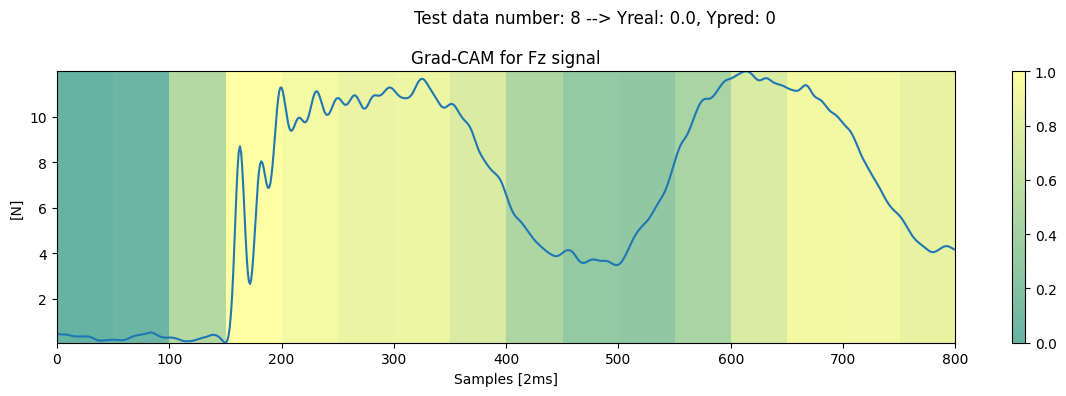

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
[2.7993187e-13]


In [4]:
plot_grad_cam(model=model, X_tests=[X_test], sample_idx=8, y_test=y_test, conv_layers=['last_conv'], labels=['Fz'])
y_pred = model.predict(X_test_)[8]
print(y_pred)

# 4 Convs + GradCam

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 800, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 196, 64)        │         1,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 98, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 48, 128)        │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 48, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 20, 128)        │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ last_conv (Conv1D)              │ (None, 7, 256)         │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_1          │ (None, 256)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 346,049 (1.32 MB)

 Trainable params: 346,049 (1.32 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.5232 - loss: 0.7443 - val_accuracy: 0.4846 - val_loss: 0.7043
Epoch 2/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6305 - loss: 0.6139 - val_accuracy: 0.7338 - val_loss: 0.5397
Epoch 3/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7238 - loss: 0.5128 - val_accuracy: 0.7611 - val_loss: 0.4729
Epoch 4/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7748 - loss: 0.4562 - val_accuracy: 0.7577 - val_loss: 0.4618
Epoch 5/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7719 - loss: 0.4721 - val_accuracy: 0.7884 - val_loss: 0.4494
Epoch 6/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.7912 - loss: 0.4287 - val_accuracy: 0.7440 - val_loss: 0.5286
Epoch 7/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.7504 - loss: 0.5141 - val_accuracy: 0.7679 - val_loss: 0.4694
Epoch 8/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8016 - loss: 0.3756 - val_accuracy: 0.8123 - v

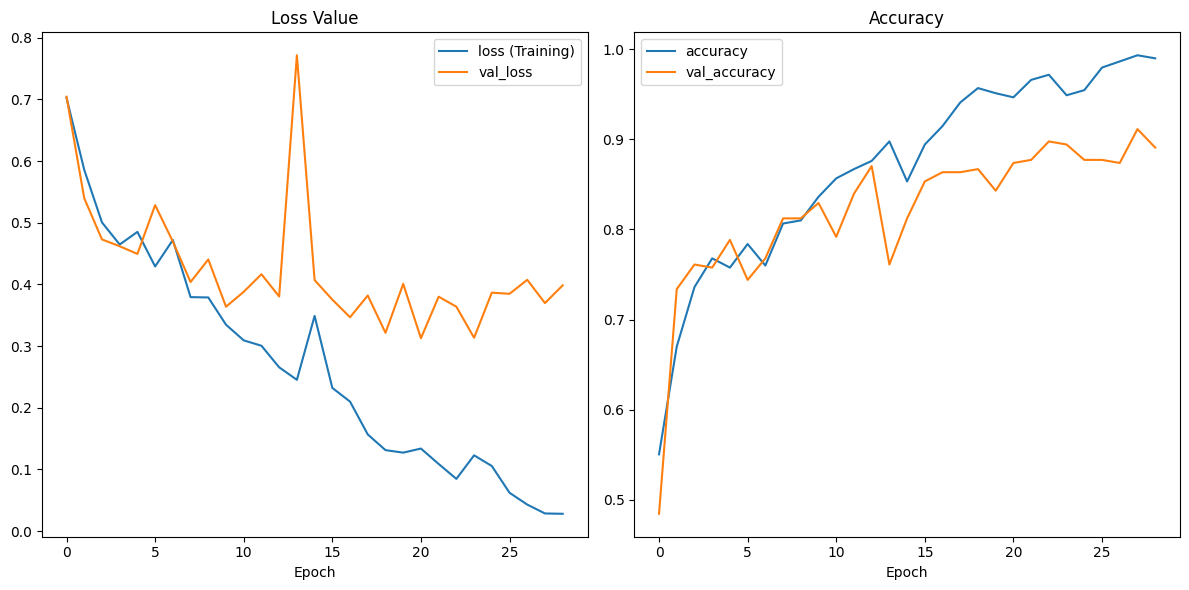

F1 Score: 0.8823529411764706
Classification Report:
               precision    recall  f1-score   support

         0.0       0.88      0.86      0.87       142
         1.0       0.87      0.89      0.88       151

    accuracy                           0.88       293
   macro avg       0.88      0.88      0.88       293
weighted avg       0.88      0.88      0.88       293



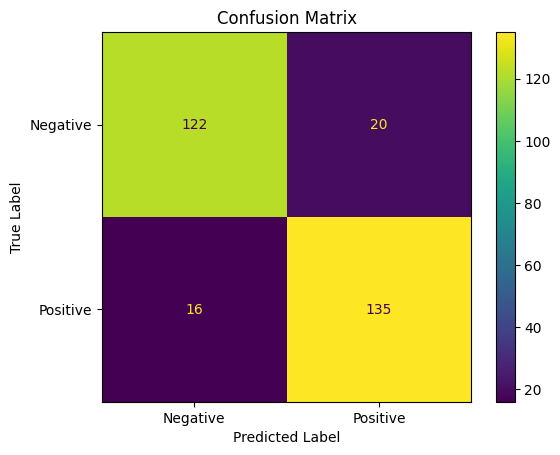

In [5]:
def build_combined_model(input_shape):
    inputlayer = Input(shape=input_shape)

    conv1 = Conv1D(filters=64, kernel_size=20, strides=4, activation='relu')(inputlayer)
    pool1 = MaxPooling1D(pool_size=2)(conv1)

    conv2 = Conv1D(filters=128, kernel_size=4, strides=2, activation='relu')(pool1)
    dropout1 = Dropout(rate=0.1)(conv2)

    conv3 = Conv1D(filters=128, kernel_size=10, strides=2, activation='relu')(dropout1)
    pool2 = MaxPooling1D(pool_size=2)(conv3)

    conv4 = Conv1D(filters=256, kernel_size=4, activation='relu', name='last_conv')(pool2)

    gap_layer = tf.keras.layers.GlobalMaxPooling1D()(conv4)

    dense1 = Dense(64, activation='relu')(gap_layer)
    outputlayer = Dense(1, activation='sigmoid')(dense1)

    model = Model(inputs=inputlayer, outputs=outputlayer)
    return model


# Reshape the input data
X_train_ = X_train.reshape(-1, 800, 1)
X_test_ = X_test.reshape(-1, 800, 1)

# Build the model
input_shape = X_train_.shape[1:]
model = build_combined_model(input_shape)
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

#TRAIN THE MODEL
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
history = model.fit(X_train_, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), verbose=1, callbacks=[early_stopping])


# Predict labels for test data
y_pred = model.predict(X_test_)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

f1 = f1_score(y_test, y_pred_binary)
accuracy = accuracy_score(y_test, y_pred_binary)

#loss, accuracy = model.evaluate(X_test_, y_test)
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].plot(history.history["loss"], label="loss (Training)")
axs[0].plot(history.history["val_loss"], label="val_loss")
axs[0].set_title("Loss Value")
axs[0].set_xlabel('Epoch')
axs[0].legend()

# Plot Accuracy
axs[1].plot(history.history["accuracy"], label="accuracy")
axs[1].plot(history.history["val_accuracy"], label="val_accuracy")
axs[1].set_title("Accuracy")
axs[1].set_xlabel('Epoch')
axs[1].legend()
#plt.suptitle(f"EasyModel TaT: {TEST_SIZE}, accur: {accuracy:.4f}, F1: {f1:.4f}, TestLoss: {loss:.4f}")
plt.tight_layout()
plt.show()


# print("Train loss:", history.history["loss"][-1])
# print("Test val_loss:", history.history["val_loss"][-1])
# print("Train accuracy:", history.history["accuracy"][-1])
# print("Accuracy Score:", accuracy)

print("F1 Score:", f1)
print("Classification Report:\n", classification_report(y_test, y_pred_binary))

plot_confusion_matrix(y_test, y_pred_binary)

# Class activation map from the input layer to the last Conv. layer


In [6]:
# layer_name = "last_conv"
# label = ["1", "0"]
# for i in range(len(X_test_)):
#     if not i%10:
#         data = np.expand_dims(X_test_[i],0)
#         pred = model.predict(data)[i][0]
#         pred_binary = (pred > 0.5).astype(int)
#         heatmap = grad_cam(model, layer_name, data)
#         print(f"Model prediction = ({pred_binary}), True label = {int(y_test[i])}")
#         plt.figure(figsize=(30,4))
#         plt.suptitle(f"Test_element #: {i}")
#         plt.imshow(np.expand_dims(heatmap,axis=2), aspect="auto", interpolation='nearest',extent=[0,800,0, np.max(X_test_[i])], alpha=0.5)
#         plt.plot(X_test_[i],'k')
#         plt.colorbar()
#         plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


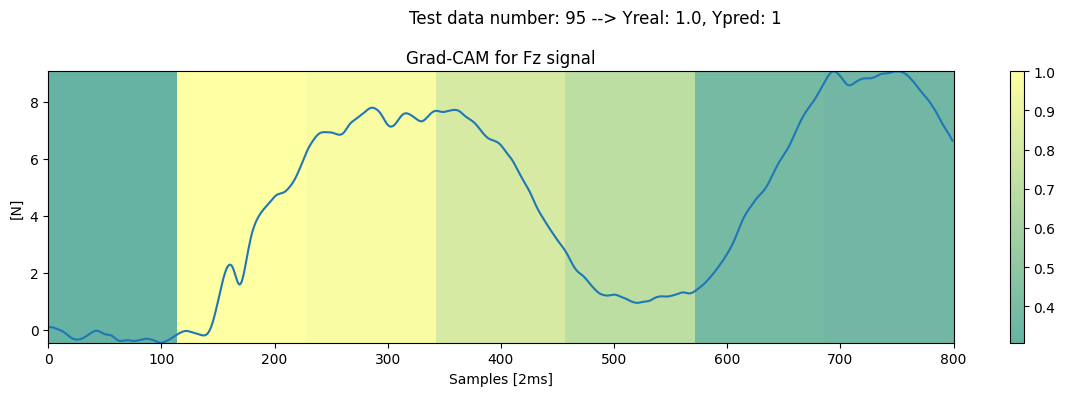

In [66]:
import random
plot_grad_cam(model, [X_test], int(random.random()*200), y_test, ['last_conv'], ['Fz'])